In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter, convolve
import scipy.stats as sps

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import cartopy.crs as ccrs
import cartopy

import xarray as xr
import glob
import time
from xarray.ufuncs import cos, deg2rad

import os
import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *;from tools.generalTools import *

xr.set_options(display_style='text') 

# Functions, etc

In [2]:
def gaussian_isotropic(x,y,sigma):
    return np.exp(-1/(2*sigma**2)*(x**2+y**2))

def gaussian(x,y,invcov):
    return np.exp(-1/2 * (invcov[0,0]*x**2 + (invcov[1,0]+invcov[0,1])*x*y + invcov[1,1]*y**2))

def u_invcov(u,v,alpha,sigma):
    sigma1 = sigma*np.sqrt(2/(1+alpha**2))#scaled std so that total variance = sigma**2
    rotation_matrix = 1/np.sqrt(u**2+v**2) * np.array([[u,v],[-v,u]])
    diag_matrix = np.diag([1/(alpha*sigma1)**2,1/sigma1**2])
    return np.dot(np.dot(rotation_matrix,diag_matrix),np.transpose(rotation_matrix))

def convolveCustom(f,g,mode='wrap'):
    """2D convolution with a space-varying kernel g
        g must have shape (f.shape[0],f.shape[1],ng,mg) where (ng,mg) is the kernel shape at each point"""
    rep=np.zeros(f.shape)
    ng,mg = g.shape[2:4]
    fpad = np.pad(f,(ng,mg),mode=mode)
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            rep[i,j] = np.sum(g[i,j][::-1,::-1]*fpad[ng+i- ng//2 : 2*ng+i- ng//2,mg+j- mg//2 : 2*mg+j- mg//2])
            
    return rep


def spaceVaryingAnisotropicKernel(U,V,sigma):
    """Return a space-varying kernel (of shape (f.shape[0],f.shape[1],ng,ng))
    where ng=4*int(sigma) is the kernel size at each point
    The kernel is basically consituted of two parts :
     - an upstream part, which is an anisotropic gaussian kernel with total variance sigma**2,
       and a std that is alpha times bigger along the vector (U[i,j],V[i,j]) than along its orthogonal direction
       where alpha depends on the vector norm
     - a downstream part that is an isotropic gaussian kernel with total variance sigma'**2 
     (sigma' chosen to match upstream kernel shape)
    """
    assert U.shape==V.shape
    kernel_size=2*int(np.ceil(sigma))
    rep = np.zeros((U.shape[0],U.shape[1],2*kernel_size+1,2*kernel_size+1))
    X_kernel,Y_kernel = np.meshgrid(np.arange(-kernel_size,kernel_size+1),np.arange(-kernel_size,kernel_size+1))

    for i in range(U.shape[0]):
        for j in range(U.shape[1]):    
            # compute the upstream half of the kernel
            u,v = U[i,j],V[i,j]
            alpha = 1+np.sqrt((u**2+v**2))
            invcov = u_invcov(u,v,alpha,sigma) #inverse covariance matrix on the upstream half of the kernel
            gauss_kernel_aniso = gaussian(X_kernel,Y_kernel,invcov)
            
            #compute the downstream half of the kernel; sigma is modified to accound for the distortion of the upstream kernel
            gauss_kernel_iso = gaussian_isotropic(X_kernel,Y_kernel,sigma*np.sqrt(2/(1+alpha**2)))
            
            #final kernel is split between upstream anisotropic part and downstream isotropic part
            gauss_kernel_final = gauss_kernel_aniso*(u*X_kernel-v*Y_kernel<=0)+gauss_kernel_iso*(u*X_kernel-v*Y_kernel>0)
            rep[i,j] = gauss_kernel_final/np.sum(gauss_kernel_final)
            
    return rep

    

In [3]:
def precip_pct(mask,precipmap,globmask=1):
    """Return the share of precipitation (in %) inside 'globmask' (whole world if globmask=1)
    that falls inside 'mask'. """
    mask2 = mask.interp_like(precipmap)
    if type(globmask)==int and globmask==1 :
        globmask2=1
    else :
        globmask2 = globmask.interp_like(precipmap)
    return 100*np.array(spatial_mean(mask2*globmask2*precipmap))/np.array(spatial_mean(globmask2*precipmap))

def objfunction_iso_smoothing(thresh,pr,predictor,globmask=1):
    """Given the map of a precipitation predictor (for example the upslope flow u.grad(z)),
    compute a mask accoding to predictor>thresh and compute the according precip enhancement and area fractions"""
    
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":0.5/dx})>0.1)
    mask=mask.interp_like(pr)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    area_fraction = spatial_mean(mask*globmask)/spatial_mean(globmask)
    precip_fraction = precip_pct(mask,pr,globmask)/100
    return 100*np.array(precip_fraction/area_fraction-1), 100*area_fraction

def objfunction_aniso_smoothing(thresh,pr,predictor,kernel):
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    unsmoothed_xr=1.*(predictor>thresh)
    t=time.time()
    rainyregion_smoothed = 1.*(convolveCustom(np.array(unsmoothed_xr),kernel)>0.01)
    print(time.time()-t)
    mask=xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)
    mask=mask.interp_like(pr)
    area_fraction = spatial_mean(mask)
    precip_fraction = precip_pct(mask,pr)/100
    return 100*np.array(precip_fraction/area_fraction-1), 100*area_fraction
    
def plotpct(ax,objfunction,lbl,args,color=0):
    #Get the range of thresholds to use on the predictor
    predictor = args[1]
    maxtresh = 0.5*np.max(np.array(predictor))
    ts = np.linspace(0.,maxtresh,10)
    
    x = np.array([objfunction(*tuple([t]+list(args))) for t in ts])
    precip_enhancements = x[:,0]
    area_fractions = x[:,1]
    
    print("threshold for 10%% : %.1e"%np.interp(10,area_fractions[::-1],ts[::-1]))
    
    if color:
        ax.plot(area_fractions,precip_enhancements,'-x',label=lbl,color=color)
    else:
        ax.plot(area_fractions,precip_enhancements,'-x',label=lbl)
    ax.set_xscale('log')
    ax.set_xlim(100,0.5)

    ax.legend()
    ax.set_xlabel("Area fraction")
    ax.set_ylabel("Precipitation enhancement")
    ax.grid()


In [4]:
pr_era5_1950_1978 = e5_monthly_timeseries('128_228_tp',years=range(1950,1979),box=None,level=None,chunks={'time':-1,'latitude':103,'longitude':80})
pr_era5_1979_2018 = e5_monthly_timeseries('128_228_tp',years=range(1979,2019),box=None,level=None,chunks={'time':-1,'latitude':103,'longitude':80})
pr_era5_all = 1000*xr.merge([pr_era5_1950_1978,pr_era5_1979_2018.rename('tp')]).tp

Re-chunking time = 0.0 s
4.389404296875
Re-chunking time = 0.0 s
14.146714687347412


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return se

In [5]:
pr_era5_mnthmean = pr_era5_all.groupby("time.month").mean("time")
pr_era5_mean = pr_era5_all.mean("time")

In [6]:
pr_trmm_all=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})*3600*24
pr_trmm_mnthmean = pr_trmm_all.groupby("time.month").mean("time")
pr_trmm_mean = pr_trmm_mnthmean.mean('month')

In [7]:
pr_gpcp_all = 86400*xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/obs4mip/observations/NASA-GSFC/Obs-GPCP/GPCP/V2.3/atmos/pr/pr_GPCP-SG_L3_v2.3_197901-201710.nc").pr.rename({'lat':'latitude','lon':'longitude'})

In [ ]:
pr_chirps_all = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/CHIRPS/chirps-v2.0.monthly.nc").precip
pr_chirps_all=pr_chirps_all/30
#days_per_month = xr.DataArray(np.array([31,28,31,30,31,30,31,31,30,31,30,31])[pr_chirps_all['time.month']-1],dims={'time':pr_chirps_all.time})
#pr_chirps_all=pr_chirps_all/days_per_month
#%time test=(pr_chirps_all.chunk({'latitude':100,'longitude':100})/days_per_month).persist()

In [11]:
#OROGRAPHY
orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

#latitude step in era5
dx5 = np.abs(np.array(ddxorog.latitude.isel(latitude=1)-ddxorog.latitude.isel(latitude=0)))

#LAND MASK
landmask = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)

In [18]:
u100m_era5_mnthmean = e5_climatology('228_246_100u',range(2010,2013))
v100m_era5_mnthmean = e5_climatology('228_247_100v',range(2010,2013))
u100m_era5_mean = u100m_era5_mnthmean.mean('month')
v100m_era5_mean = v100m_era5_mnthmean.mean('month')

ugradz_era5_mnthmean = (u100m_era5_mnthmean*ddxorog + v100m_era5_mnthmean*ddyorog)
ugradz_era5_mean = ugradz_era5_mnthmean.mean('month')
ugradz_era5_mean_s  = xr.apply_ufunc(gaussian_filter,ugradz_era5_mean  ,kwargs={"sigma":.5/dx5})

viwve_era5_mnthmean = e5_climatology('162_071_viwve',range(1975,1978))
viwvn_era5_mnthmean = e5_climatology('162_072_viwvn',range(1975,1978))

viwvgradz_era5_mnthmean = (viwve_era5_mnthmean*ddxorog + viwvn_era5_mnthmean*ddyorog)
viwvgradz_era5_mean = viwvgradz_era5_mnthmean.mean('month')
viwvgradz_era5_mean_s  = xr.apply_ufunc(gaussian_filter,viwvgradz_era5_mean  ,kwargs={"sigma":.5/dx5})

15.82847809791565
1.6605136394500732
0.9965724945068359
1.0722365379333496


In [8]:
q925_era5_mnthmean = e5_climatology('128_133_q',range(2010,2013)).sel(level=925.)
q925_ugradz_era5_mnthmean = q925_era5_mnthmean*ugradz_era5_mnthmean
q925_ugradz_era5_mean  = q925_era5_mnthmean.mean('month')*ugradz_era5_mean
q925_ugradz_era5_mean_s  = xr.apply_ufunc(gaussian_filter,q925_ugradz_era5_mean  ,kwargs={"sigma":.5/dx5})

55.49787521362305


In [ ]:
def timesel(month,monthinf,monthsup):
    return (np.mod(month - monthinf,12) < np.mod(monthsup - monthinf,12)) & (np.mod(monthsup - month,12) <= np.mod(monthsup - monthinf,12))

q925_ugradz_era5_seasonal = []
viwvgradz_era5_seasonal = []
pr_trmm_seasonal = []
pr_era5_seasonal = []
u100m_era5_seasonal = []
v100m_era5_seasonal = []

for season in [(12,3),(3,6),(6,9),(9,12)]:
    q925_ugradz_era5_seasonal.append( q925_ugradz_era5_mnthmean.sel(month = timesel(q925_ugradz_era5_mnthmean['month'],season[0],season[1])).mean('month'))
    viwvgradz_era5_seasonal.append( viwvgradz_era5_mnthmean.sel(month = timesel(viwvgradz_era5_mnthmean['month'],season[0],season[1])).mean('month'))
    pr_trmm_seasonal.append(pr_trmm_mnthmean.sel(month = timesel(pr_trmm_mnthmean['month'],season[0],season[1])).mean('month'))
    pr_era5_seasonal.append(pr_era5_mnthmean.sel(month = timesel(pr_era5_mnthmean['month'],season[0],season[1])).mean('month'))
    u100m_era5_seasonal.append(u100m_era5_mnthmean.sel(month = timesel(pr_era5_mnthmean['month'],season[0],season[1])).mean('month'))
    v100m_era5_seasonal.append(v100m_era5_mnthmean.sel(month = timesel(pr_era5_mnthmean['month'],season[0],season[1])).mean('month'))
    

# Land + Ocean

## All-year mean

threshold for 10% : 7.6e-02
threshold for 10% : 1.6e-05
threshold for 10% : 7.6e-02
threshold for 10% : 1.6e-05
threshold for 10% : 6.8e-02
threshold for 10% : 1.4e-05


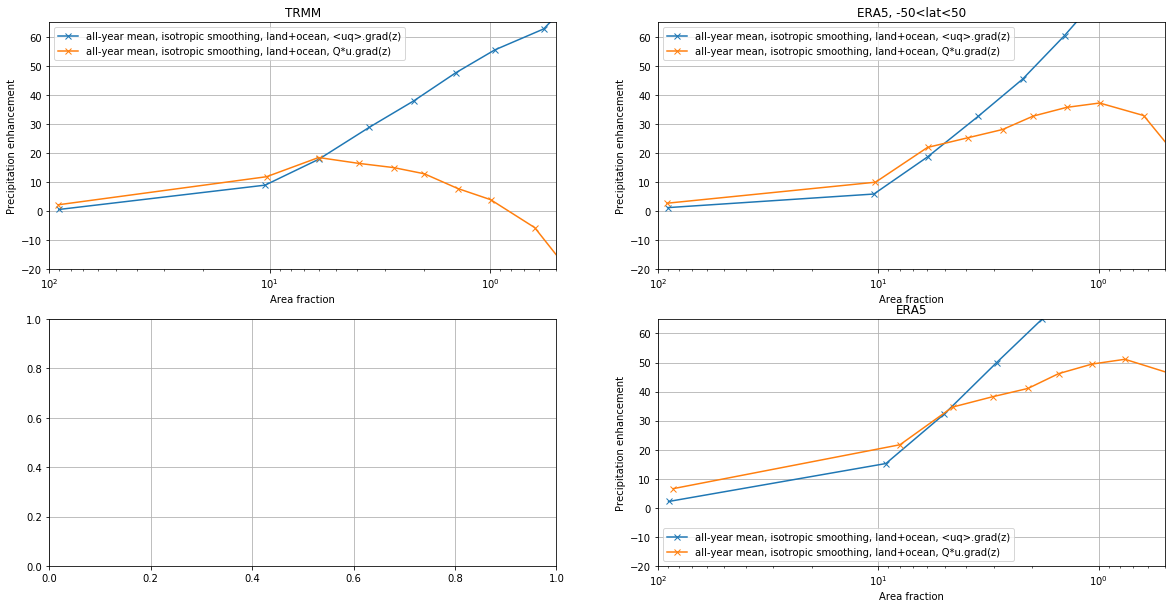

In [12]:
_,ax = plt.subplots(2,2,figsize=(20,10))

plotpct(ax[0][0],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, <uq>.grad(z)",[pr_trmm_mean,viwvgradz_era5_mean_s  ])
plotpct(ax[0][0],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q925*u.grad(z)", [pr_trmm_mean,q925_ugradz_era5_mean_s])
ax[0][0].set_title("TRMM")
ax[0][0].set_ylim(-20,65)

plotpct(ax[0][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, <uq>.grad(z)",[pr_era5_mean.sel(latitude=slice(50,-50)),viwvgradz_era5_mean_s  ])
plotpct(ax[0][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q925*u.grad(z)", [pr_era5_mean.sel(latitude=slice(50,-50)),q925_ugradz_era5_mean_s])
ax[0][1].set_title("ERA5, -50<lat<50")
ax[0][1].set_ylim(-20,65)

plotpct(ax[1][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, <uq>.grad(z)",[pr_era5_mean,viwvgradz_era5_mean_s  ])
plotpct(ax[1][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, Q925*u.grad(z)", [pr_era5_mean,q925_ugradz_era5_mean_s])
ax[1][1].set_title("ERA5")
ax[1][1].set_ylim(-20,65)

for a in ax.reshape(-1): a.grid()


## Seasonal means

threshold for 10% : 5.7e-05
threshold for 10% : 2.2e-01
threshold for 10% : 5.7e-05
threshold for 10% : 2.2e-01
threshold for 10% : 5.6e-05
threshold for 10% : 2.2e-01
threshold for 10% : 5.5e-05
threshold for 10% : 3.0e-01
threshold for 10% : 5.5e-05
threshold for 10% : 3.0e-01
threshold for 10% : 5.4e-05
threshold for 10% : 3.0e-01
threshold for 10% : 6.9e-05
threshold for 10% : 3.6e-01
threshold for 10% : 6.9e-05
threshold for 10% : 3.6e-01
threshold for 10% : 6.7e-05
threshold for 10% : 3.6e-01
threshold for 10% : 5.5e-05
threshold for 10% : 1.9e-01
threshold for 10% : 5.5e-05
threshold for 10% : 1.9e-01
threshold for 10% : 5.4e-05
threshold for 10% : 1.9e-01


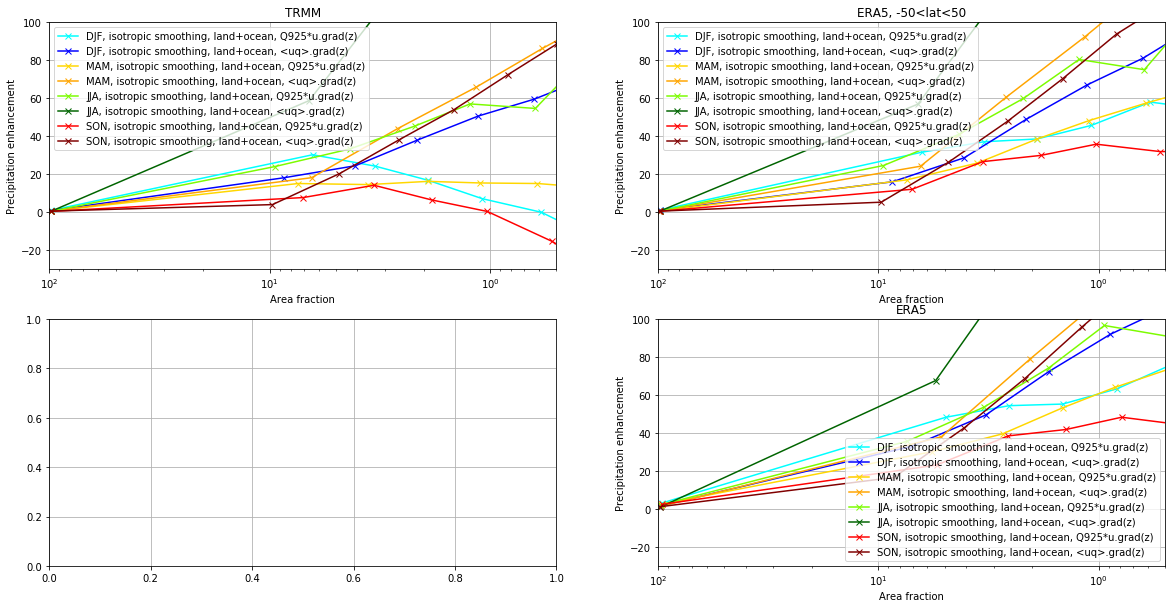

In [16]:
_,ax = plt.subplots(2,2,figsize=(20,10))

color=[["cyan","blue"],["gold","orange"],["lawngreen","darkgreen"],["red","maroon"]]
for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plotpct(ax[0][0],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q925*u.grad(z)"%seasonname,[pr_trmm_seasonal[season],q925_ugradz_era5_seasonal[season] ],color=color[season][0])
    plotpct(ax[0][0],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, <uq>.grad(z)"%seasonname,[pr_trmm_seasonal[season],viwvgradz_era5_seasonal[season] ]    ,color=color[season][1])
    ax[0][0].set_ylim(-30,100)
    ax[0][0].set_title("TRMM")
    
    plotpct(ax[0][1],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q925*u.grad(z)"%seasonname,[pr_era5_seasonal[season].sel(latitude=slice(50,-50)),q925_ugradz_era5_seasonal[season] ],color=color[season][0])
    plotpct(ax[0][1],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, <uq>.grad(z)"%seasonname,[pr_era5_seasonal[season].sel(latitude=slice(50,-50)),viwvgradz_era5_seasonal[season] ]    ,color=color[season][1])
    ax[0][1].set_title("ERA5, -50<lat<50")
    ax[0][1].set_ylim(-30,100)
    
    plotpct(ax[1][1],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, Q925*u.grad(z)"%seasonname,[pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season] ],color=color[season][0])
    plotpct(ax[1][1],objfunction_iso_smoothing,"%s, isotropic smoothing, land+ocean, <uq>.grad(z)"%seasonname,[pr_era5_seasonal[season],viwvgradz_era5_seasonal[season] ]    ,color=color[season][1])
    ax[1][1].set_title("ERA5")
    ax[1][1].set_ylim(-30,100)

for a in ax.reshape(-1): a.grid()
    

# With anisotropic smoothing

In [18]:
t=time.time()
kernel_mean = spaceVaryingAnisotropicKernel(np.array(u100m_era5_mean),np.array(v100m_era5_mean),4)
print(time.time()-t)
#kernel_seasonal = []
#for i in range(4):
#    kernel_seasonal.append(spaceVaryingAnisotropicKernel(np.array(u100m_era5_seasonal[i]),np.array(v100m_era5_seasonal[i]),4))
#    print(time.time()-t)

189.81985354423523


threshold for 10% : 6.8e-02
12.142290830612183
11.844504356384277
16.21654438972473
17.54777193069458
11.864427328109741
11.590122699737549
10.699099063873291
11.96399736404419
10.985810041427612
12.03024411201477
threshold for 10% : 1.3e-01


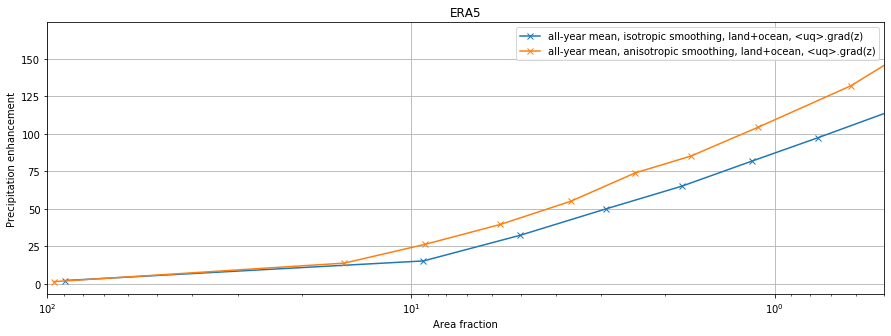

In [23]:
_,ax = plt.subplots(1,1,figsize=(15,5))

plotpct(ax,objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land+ocean, <uq>.grad(z)", [pr_era5_mean,viwvgradz_era5_mean_s])
plotpct(ax,objfunction_aniso_smoothing,"all-year mean, anisotropic smoothing, land+ocean, <uq>.grad(z)", [pr_era5_mean,viwvgradz_era5_mean_s,kernel_mean])
ax.set_title("ERA5")
ax.grid()

# Land only

## All-year mean

threshold for 10% : 2.4e-01
threshold for 10% : 5.4e-05
threshold for 10% : 2.4e-01
threshold for 10% : 5.4e-05
threshold for 10% : 1.9e-01
threshold for 10% : 3.9e-05


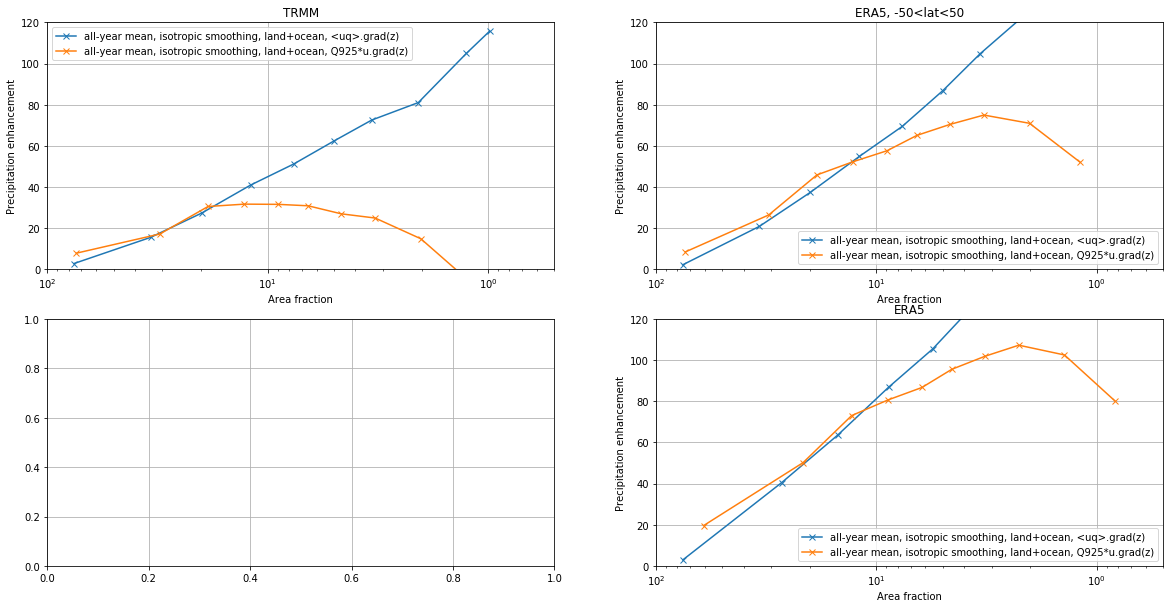

In [20]:
_,ax = plt.subplots(2,2,figsize=(20,10))

plotpct(ax[0][0],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land only, <uq>.grad(z)",[pr_trmm_mean,viwvgradz_era5_mean_s   ,landmask])
plotpct(ax[0][0],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land only, Q925*u.grad(z)", [pr_trmm_mean,q925_ugradz_era5_mean_s ,landmask])
ax[0][0].set_title("TRMM")
ax[0][0].set_ylim(0,120)

plotpct(ax[0][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land only, <uq>.grad(z)",[pr_era5_mean.sel(latitude=slice(50,-50)),viwvgradz_era5_mean_s   ,landmask])
plotpct(ax[0][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land only, Q925*u.grad(z)", [pr_era5_mean.sel(latitude=slice(50,-50)),q925_ugradz_era5_mean_s ,landmask])
ax[0][1].set_title("ERA5, -50<lat<50")
ax[0][1].set_ylim(0,120)


plotpct(ax[1][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land only, <uq>.grad(z)",[pr_era5_mean,viwvgradz_era5_mean_s   ,landmask])
plotpct(ax[1][1],objfunction_iso_smoothing,"all-year mean, isotropic smoothing, land only, Q925*u.grad(z)", [pr_era5_mean,q925_ugradz_era5_mean_s ,landmask])
ax[1][1].set_title("ERA5")
ax[1][1].set_ylim(0,120)

for a in ax.reshape(-1): a.grid()


# Maps

In [79]:
def plot_pr_mask(ax,thresh,pr,predictor,globmask,smoothfactor=1.):
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":smoothfactor*0.5/dx})>0.1)
    mask=mask.interp_like(pr)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    m=12.
    (globmask*pr).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,m,50),add_colorbar=False) #,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)}
    kw = {'levels':[0.5], 'colors':['w']}
    mask.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
    ax.coastlines()
    print("Area fraction = %.2f %%"%(100*spatial_mean(mask*globmask)/spatial_mean(globmask)))
    
def plot_pr_anisotropic_mask(ax,thresh,pr,predictor,kernel):
    unsmoothed_xr=1.*(predictor>thresh)
    t=time.time()
    rainyregion_smoothed = 1.*(convolveCustom(np.array(unsmoothed_xr),kernel)>0.01)
    print(time.time()-t)
    mask=xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)
    mask=mask.interp_like(pr)
    
    m=12.
    pr.plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,m,50),add_colorbar=False)#,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)}
    kw = {'levels':[0.5], 'colors':['w']}
    mask.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
    ax.coastlines()    
    print("Area fraction = %.2f %%"%(100*spatial_mean(mask)))

Area fraction = 5.09 %
Area fraction = 5.11 %
Area fraction = 5.14 %
Area fraction = 5.11 %
Area fraction = 5.23 %
Area fraction = 4.95 %
Area fraction = 5.14 %
Area fraction = 5.12 %
Area fraction = 5.14 %
Area fraction = 4.93 %


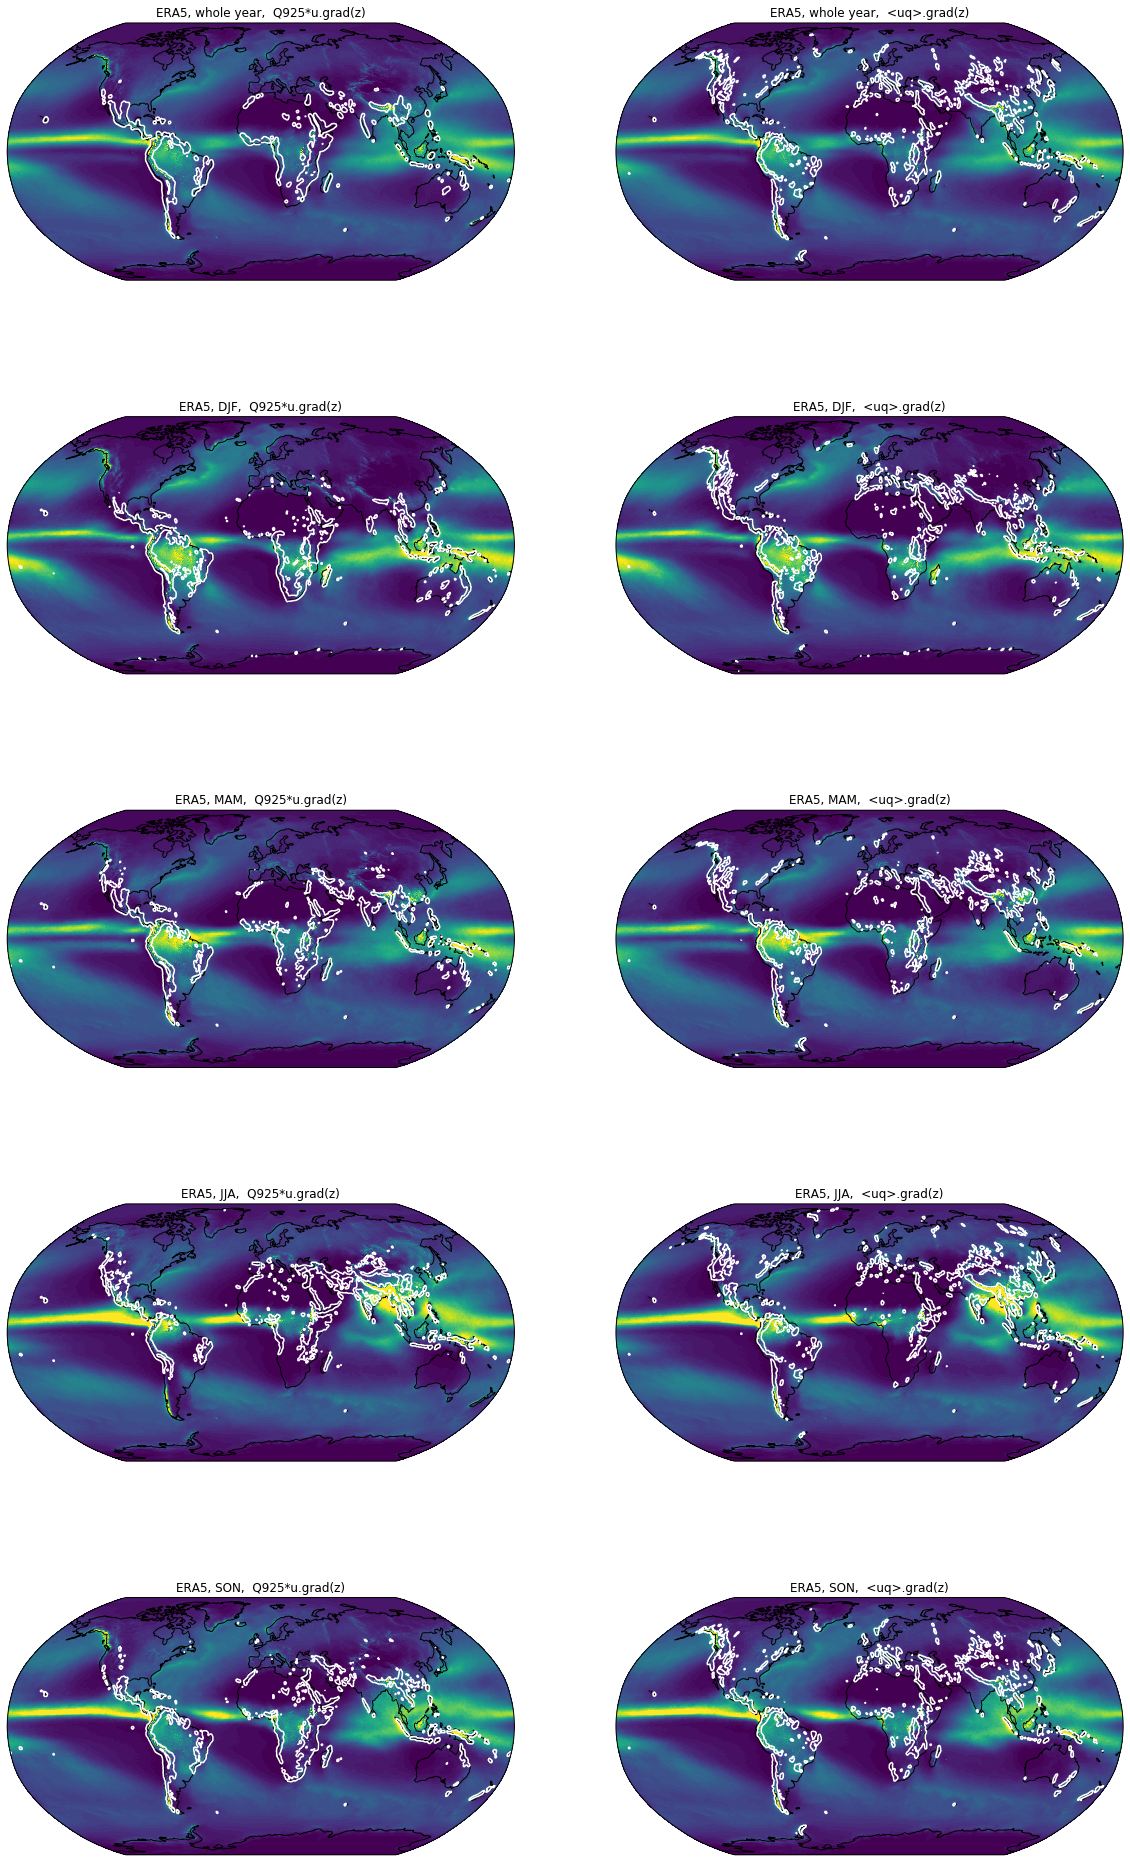

In [83]:

fig, ax = plt.subplots(5,2,figsize=(20,35),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax[0][0],2.6e-05,pr_era5_mean,q925_ugradz_era5_mean_s,1)
plot_pr_mask(ax[0][1],0.32,pr_era5_mean,viwvgradz_era5_seasonal[season],1)
ax[0][0].set_title("ERA5, whole year,  Q925*u.grad(z)")
ax[0][1].set_title("ERA5, whole year,  <uq>.grad(z)")

threshs = [5.7e-05,6.2e-05,10e-05,6e-05]
threshs_vi = [0.31,0.33,0.4,0.33]
for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plot_pr_mask(ax[season+1][0],threshs[season],pr_era5_seasonal[season],q925_ugradz_era5_seasonal[season],1)
    plot_pr_mask(ax[season+1][1],threshs_vi[season],pr_era5_seasonal[season],viwvgradz_era5_seasonal[season],1)
    ax[season+1][0].set_title("ERA5, %s,  Q925*u.grad(z)"%seasonname)
    ax[season+1][1].set_title("ERA5, %s,  <uq>.grad(z)"%seasonname)



Area fraction = 5.09 %


Text(0.5, 1.0, 'ERA5, whole year,  <uq>.grad(z)')

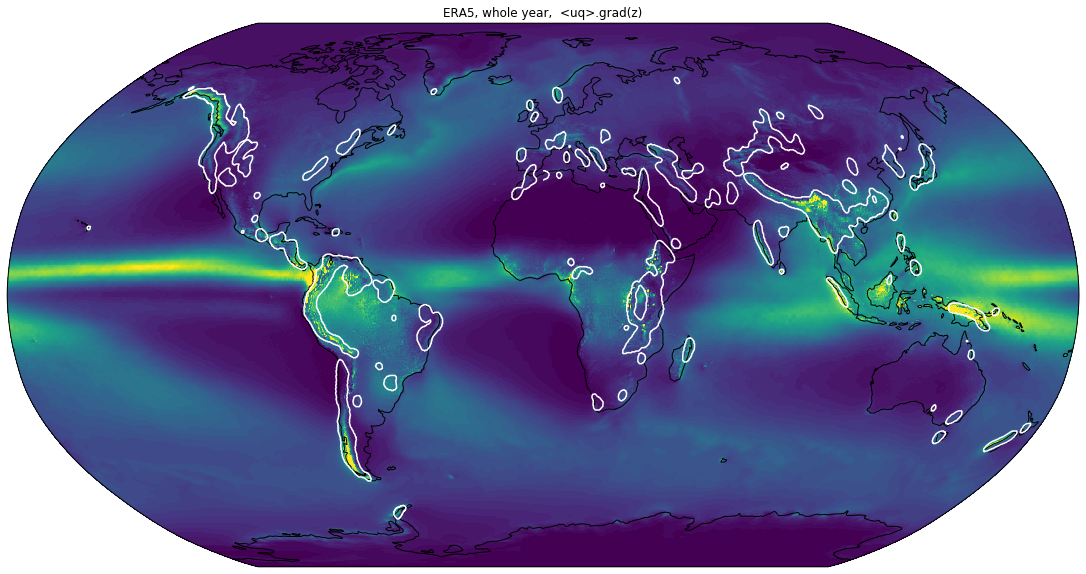

In [80]:

fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax,0.34,pr_era5_mean,viwvgradz_era5_mean,1,smoothfactor=2.)
ax.set_title("ERA5, whole year,  <uq>.grad(z)")


Area fraction = 5.03 %


Text(0.5, 1.0, 'ERA5, whole year,  u100m.grad(z)')

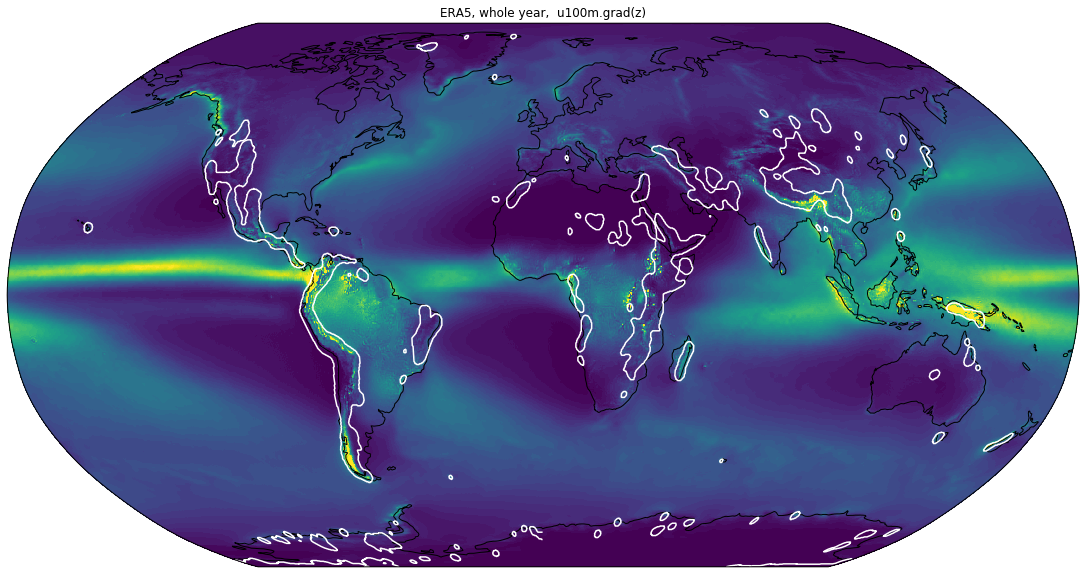

In [82]:

fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax,8.3e-3,pr_era5_mean,ugradz_era5_mean,1,smoothfactor=2.)
ax.set_title("ERA5, whole year,  u100m.grad(z)")


In [128]:
from tabulate import tabulate
import copy

orogmask = 1.*(orog>orog.quantile(0.8,["latitude","longitude"]))

tab = [["Land+ocean"],["Land only "],["Orog 80th percentile"]]
tab2=[x[:] for x in tab]
for pred in [ugradz_era5_mean,q925_ugradz_era5_mean,viwvgradz_era5_mean]:
    tab[0].append("%.2f"%np.corrcoef(np.reshape(np.array(pr_era5_mean),-1),
                                     np.reshape(np.maximum(0.,np.array(pred)),-1))[1,0])
    tab[1].append("%.2f"%np.corrcoef(np.reshape(np.array(pr_era5_mean*landmask),-1),
                                     np.reshape(np.maximum(0.,np.array(pred*landmask)),-1))[1,0])
    tab[2].append("%.2f"%np.corrcoef(np.reshape(np.array(pr_era5_mean*orogmask),-1),
                                     np.reshape(np.maximum(0.,np.array(pred*orogmask)),-1))[1,0])
    tab2[0].append("%.2f"%np.corrcoef(np.nan_to_num(np.reshape(np.array(pr_trmm_mean),-1)),
                                      np.nan_to_num(np.reshape(np.maximum(0.,np.array(pred.interp_like(pr_trmm_mean))),-1)))[1,0])
    tab2[1].append("%.2f"%np.corrcoef(np.nan_to_num(np.reshape(np.array(pr_trmm_mean*landmask.interp_like(pr_trmm_mean)),-1)),
                                      np.nan_to_num(np.reshape(np.maximum(0.,np.array((pred*landmask).interp_like(pr_trmm_mean))),-1)))[1,0])
    tab2[2].append("%.2f"%np.corrcoef(np.nan_to_num(np.reshape(np.array(pr_trmm_mean*orogmask.interp_like(pr_trmm_mean)),-1)),
                                      np.nan_to_num(np.reshape(np.maximum(0.,np.array((pred*orogmask).interp_like(pr_trmm_mean))),-1)))[1,0])


print(tabulate(tab, headers=['CORRELATION - ERA5 precip/','u.grad(z)_+', 'q925*u.grad(z)_+', '<uq>.grad(z)_+']))
print()
print(tabulate(tab2, headers=['CORRELATION - TRMM precip/','u.grad(z)_+', 'q925*u.grad(z)_+', '<uq>.grad(z)_+']))


CORRELATION - ERA5 precip/      u.grad(z)_+    q925*u.grad(z)_+    <uq>.grad(z)_+
----------------------------  -------------  ------------------  ----------------
Land+ocean                             0.01                0.12              0.12
Land only                              0.25                0.35              0.38
Orog 80th percentile                   0.31                0.42              0.45

CORRELATION - TRMM precip/      u.grad(z)_+    q925*u.grad(z)_+    <uq>.grad(z)_+
----------------------------  -------------  ------------------  ----------------
Land+ocean                            -0.04                0.02              0.06
Land only                              0.23                0.29              0.35
Orog 80th percentile                   0.32                0.39              0.44


In [6]:
quantile = 0.9
print("area fraction (over whole globe) : %.2f %%"%(100*spatial_mean(1.*(orog>orog.quantile(quantile,["latitude","longitude"])))))

area fraction (over whole globe) : 4.45 %


In [12]:
print(orog.quantile(0.8,["latitude","longitude"]))

<xarray.DataArray 'Z' ()>
array(412.10977173)
Coordinates:
    quantile  float64 0.8


# Figures for Ruby Leung

In [13]:
def plot_pr_mask(ax,thresh,pr,predictor,globmask):
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":0.5/dx})>0.1)
    mask=mask.interp_like(pr)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    m=12.
    print("Area fraction = %.2f %%"%(100*spatial_mean(mask*globmask)/spatial_mean(globmask)))
    (globmask*pr).plot(ax=ax,transform=ccrs.PlateCarree(),levels=np.linspace(0.,m,50),add_colorbar=False) #,cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)}
    kw = {'levels':[0.5], 'colors':['w']}
    mask.plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)
    ax.coastlines()
    

In [10]:
viwvgradz_era5_mean_s=xr.apply_ufunc(gaussian_filter,viwvgradz_era5_mean  ,kwargs={"sigma":2.})

Area fraction = 10.12 %


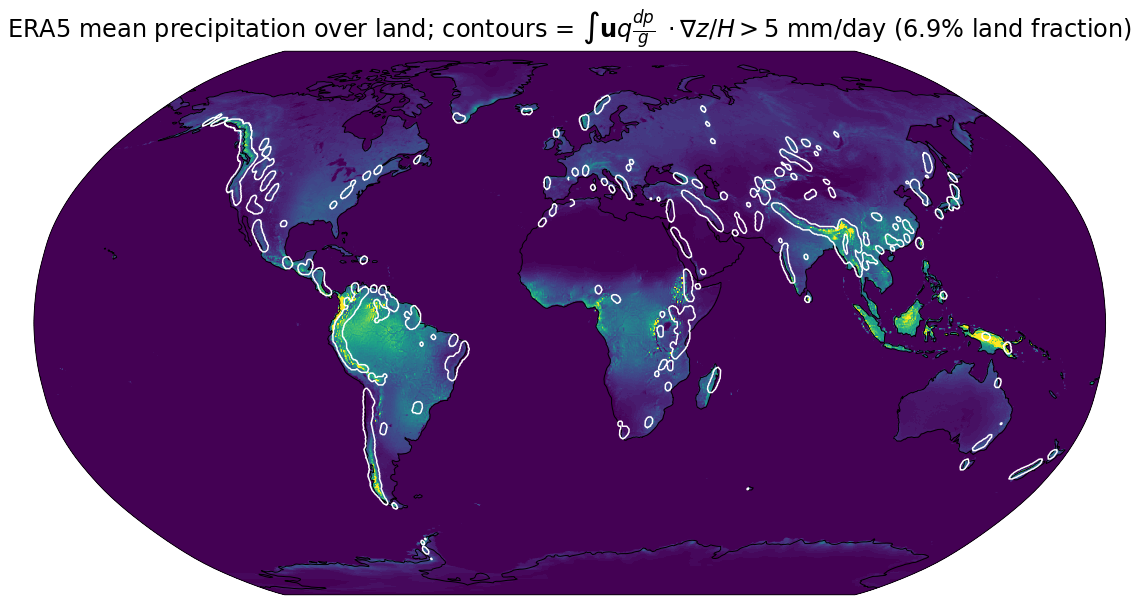

In [16]:
matplotlib.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax,0.185,pr_era5_mean,viwvgradz_era5_mean_s,landmask)
ax.set_title("ERA5 mean precipitation over land; contours = "+r"$\int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z / H > 5$ mm/day (6.9% land fraction)")
matplotlib.rcParams.update({'font.size': 20})

Area fraction = 6.88 %


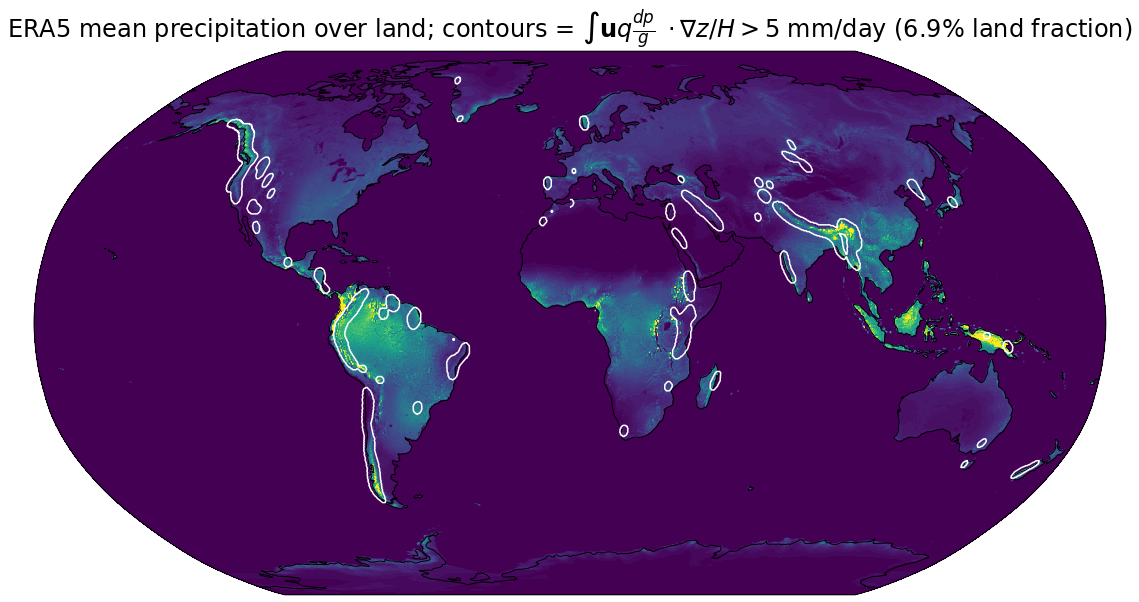

In [16]:
matplotlib.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
plot_pr_mask(ax,0.144,pr_era5_mean,viwvgradz_era5_mean_s,landmask)
ax.set_title("ERA5 mean precipitation over land; contours = "+r"$\int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z / H > 5$ mm/day (6.9% land fraction)")
matplotlib.rcParams.update({'font.size': 20})

In [25]:
def plotpct(ax,objfunction,lbl,args,color=0,threshfact=1):
    #Get the range of thresholds to use on the predictor
    predictor = args[1]
    maxtresh = threshfact*0.5*np.max(np.array(predictor))
    ts = np.linspace(0.,maxtresh,10)
    
    x = np.array([objfunction(*tuple([t]+list(args))) for t in ts])
    precip_enhancements = x[:,0]
    area_fractions = x[:,1]
    
    print("threshold for 10%% : %.1e"%np.interp(10,area_fractions[::-1],ts[::-1]))
    
    if color==0:
        ax.plot(area_fractions,precip_enhancements,'-x',label=lbl)
    else:
        ax.plot(area_fractions,precip_enhancements,'-x',label=lbl,color=color)
    ax.set_xscale('log')
    ax.set_xlim(100,0.5)

    ax.legend()
    ax.set_xlabel("Land fraction (%)")
    ax.set_ylabel("Precipitation enhancement (%)")
    ax.grid()

threshold for 10% : 5.7e-01
threshold for 10% : 4.4e-01
threshold for 10% : 6.1e-01
threshold for 10% : 5.2e-01
threshold for 10% : 7.1e-01
threshold for 10% : 6.1e-01
threshold for 10% : 5.5e-01
threshold for 10% : 4.6e-01
threshold for 10% : 2.4e-01
threshold for 10% : 2.0e-01


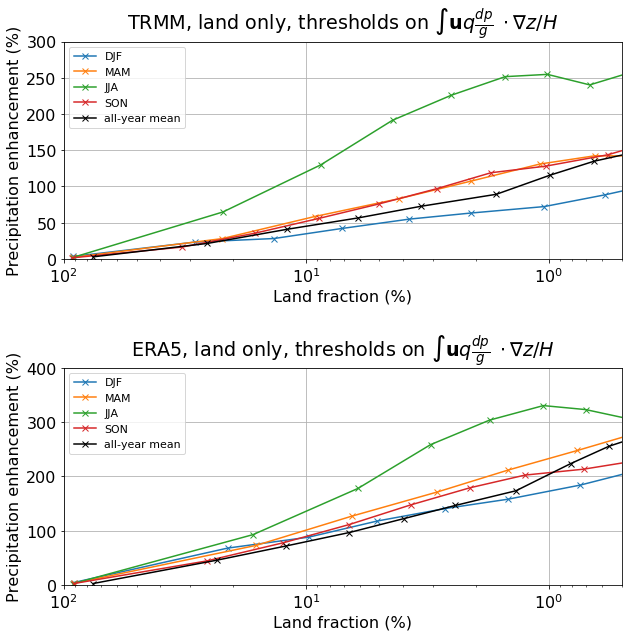

In [27]:
matplotlib.rcParams.update({'font.size': 16})
_,ax = plt.subplots(2,1,figsize=(10,10))

for season,seasonname in enumerate(['DJF','MAM','JJA','SON']):
    plotpct(ax[0],objfunction_iso_smoothing,seasonname,[pr_trmm_seasonal[season],viwvgradz_era5_seasonal[season] ,landmask])
    plotpct(ax[1],objfunction_iso_smoothing,seasonname,[pr_era5_seasonal[season],viwvgradz_era5_seasonal[season] ,landmask])

ax[0].set_ylim(0,300)
ax[1].set_ylim(0,400)
ax[0].set_title("TRMM, land only, thresholds on "+r"$\int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z / H$")
ax[1].set_title("ERA5, land only, thresholds on "+r"$\int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z / H$")

    
plotpct(ax[0],objfunction_iso_smoothing,"all-year mean" ,[pr_trmm_mean,viwvgradz_era5_mean_s   ,landmask],color='k',threshfact=1.5)
plotpct(ax[1],objfunction_iso_smoothing,"all-year mean" ,[pr_era5_mean,viwvgradz_era5_mean_s   ,landmask],color='k',threshfact=1.2)


for a in ax.reshape(-1): a.grid()
matplotlib.rcParams.update({'font.size': 16})
ax[0].legend(prop={"size":11})
ax[1].legend(prop={"size":11})

plt.subplots_adjust(hspace=0.5)


for a in ax.reshape(-1): a.grid()


# Maps of $VIMF\cdot \nabla h$ and $H_{sat}$

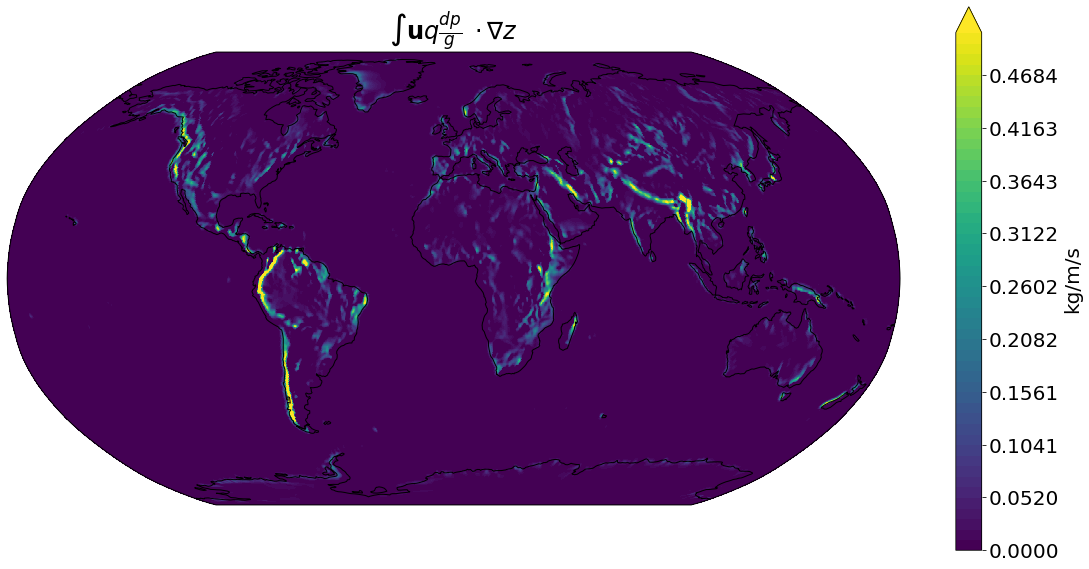

In [38]:
matplotlib.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
xr.ufuncs.maximum(viwvgradz_era5_mean_s,0.).plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"kg/m/s"},levels=np.linspace(0.,0.51))
ax.set_title(r"$\int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z$")
ax.coastlines()

In [12]:
q_seasmean = xr.open_dataset("/global/homes/q/qnicolas/autumnMonsoon/e5.moda.an.pl.128_133_q.ll025sc.1979010100_2018123123.seasonalmean.nc").Q
q_mean = q_seasmean.mean("month")

In [13]:
test=q_mean.isel(longitude=200,latitude=200)
test
dqdz=test.differentiate("level")
Htest = test/dqdz

In [14]:
t_seasmean = xr.open_dataset("/global/homes/q/qnicolas/autumnMonsoon/e5.moda.an.pl.128_130_t.ll025sc.1979010100_2018123123.seasonalmean.nc").T
t_mean=t_seasmean.mean("month")
rho_mean=t_mean.level*100/t_mean/287.

In [15]:
ps_seasmean = xr.open_dataset("/global/cscratch1/sd/qnicolas/era5monthly/e5.moda.an.sfc/e5.moda.an.sfc.128_134_sp.ll025sc.2000010100_2000120100.nc").SP
ps_mean=ps_seasmean.mean("time")


In [16]:
H=q_mean/(q_mean.differentiate("level")/100 *9.81*rho_mean)

In [17]:
H_pmean = H.sel(level=slice(500,1000)).where(H.level<ps_mean/100).mean("level")
#H_pmean_s

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


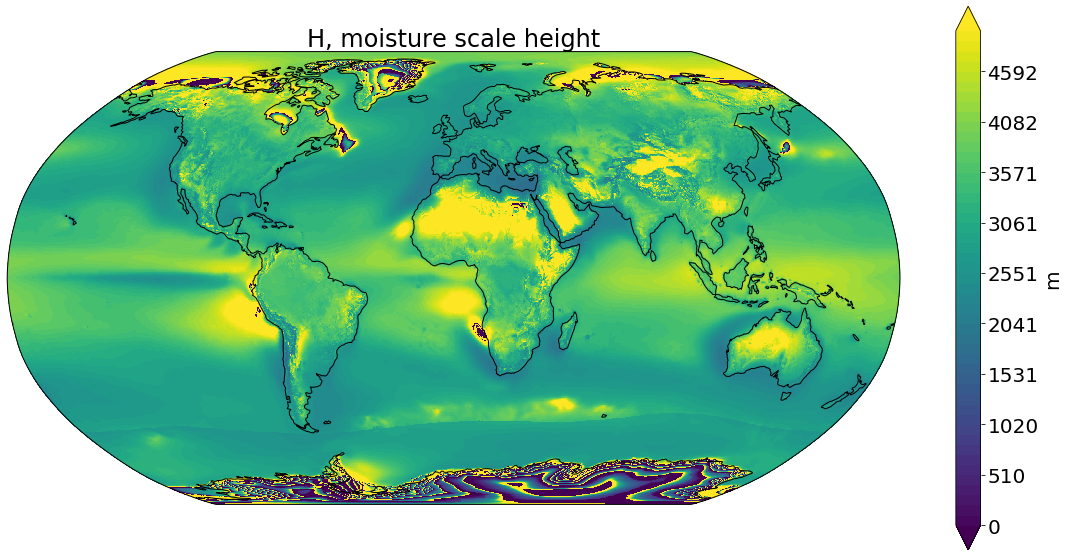

In [40]:
matplotlib.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
H_pmean.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"m"},levels=np.linspace(0,5000),cmap=plt.cm.viridis)
ax.set_title("H, moisture scale height")
ax.coastlines()

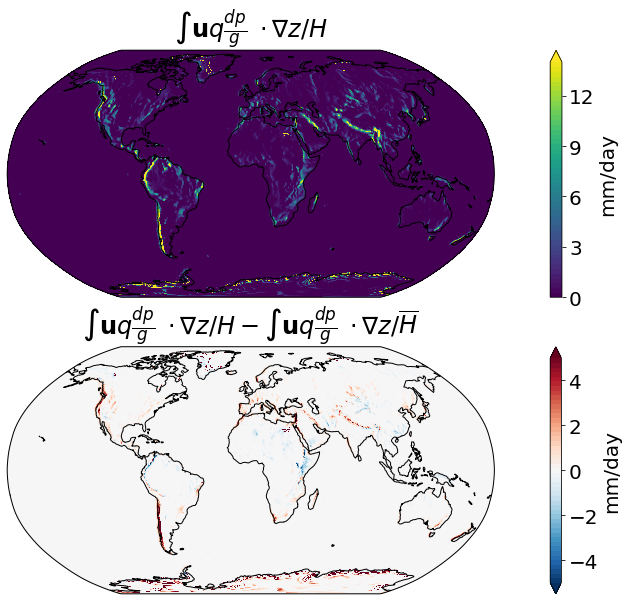

In [24]:
viwvgradz_h = ((86400/xr.ufuncs.maximum(H_pmean,100.))*xr.ufuncs.maximum(viwvgradz_era5_mean_s,0.))
viwvgradz_hmean = ((86400/spatial_mean(xr.ufuncs.maximum(H_pmean,100.).sel(latitude=slice(50,-50))))*xr.ufuncs.maximum(viwvgradz_era5_mean_s,0.))


matplotlib.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(2,1,figsize=(20,10),subplot_kw={'projection': ccrs.Robinson()})
viwvgradz_h.plot(ax=ax[0],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":range(0,15,3)},levels=np.linspace(0.,14.))
ax[0].set_title(r"$\int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z /H$")
ax[0].coastlines()

(viwvgradz_h-viwvgradz_hmean).plot(ax=ax[1],transform=ccrs.PlateCarree(),cbar_kwargs={"label":"mm/day","ticks":range(-4,5,2)},levels=np.linspace(-5.,5.))
ax[1].set_title(r"$\int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z /H - \int \mathbf{u}q \frac{dp}{g}\;\cdot\nabla z / \overline{H}$")
ax[1].coastlines()

# Trends

## Global mean precip

In [38]:
pr_era5_globmean = spatial_mean(pr_era5_all,box=None,mask=None).load()
pr_gpcp_globmean = spatial_mean(pr_gpcp_all,box=None,mask=None).load()

Text(0.5, 1.0, 'Global mean precipitation')

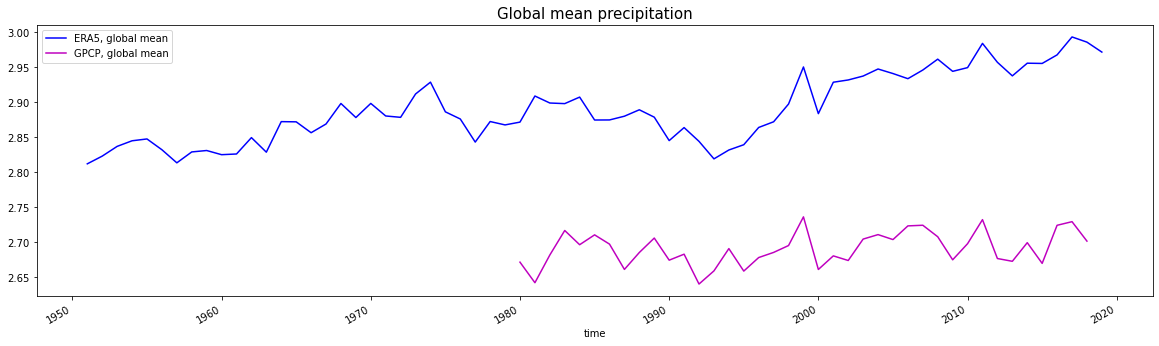

In [39]:
plt.figure(figsize=(20,5))
pr_era5_globmean.resample(time='1Y').mean().plot(color='b',label='ERA5, global mean')
pr_gpcp_globmean.resample(time='1Y').mean().plot(color='m',label='GPCP, global mean')
plt.legend()
plt.title("Global mean precipitation",fontsize=15)

In [40]:
reg=pr_era5_globmean.resample(time='1Y').mean()
print('ERA5 :',sps.linregress(range(len(reg)),np.array(reg)))
reg=pr_gpcp_globmean.resample(time='1Y').mean()
print('GPCP :',sps.linregress(range(len(reg)),np.array(reg)))


ERA5 : LinregressResult(slope=0.001959155195596492, intercept=2.8234632148505736, rvalue=0.8046263309433784, pvalue=8.152854050121581e-17, stderr=0.00017662975214767813)
GPCP : LinregressResult(slope=0.0007582227358936396, intercept=2.676489817222114, rvalue=0.3548921520707676, pvalue=0.02662914706400872, stderr=0.00032837347696210503)


In [41]:
pr_era5_50mean = spatial_mean(pr_era5_all,box=None,mask=np.abs(pr_era5_all.latitude)<=50).load()
pr_gpcp_50mean = spatial_mean(pr_gpcp_all,box=None,mask=np.abs(pr_gpcp_all.latitude)<=50).load()
pr_trmm_50mean = spatial_mean(pr_trmm_all).load()
#pr_chirps_50mean = spatial_mean(pr_chirps_all).load()

Text(0.5, 1.0, '50S-50N mean precipitation')

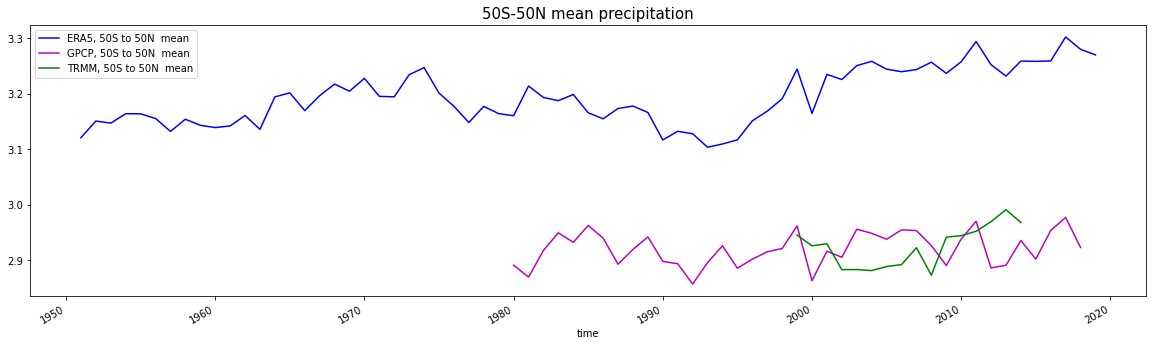

In [42]:
plt.figure(figsize=(20,5))
pr_era5_50mean.resample(time='1Y').mean().plot(color='b',label='ERA5, 50S to 50N  mean')
pr_gpcp_50mean.resample(time='1Y').mean().plot(color='m',label='GPCP, 50S to 50N  mean')
pr_trmm_50mean.resample(time='1Y').mean().plot(color='g',label='TRMM, 50S to 50N  mean')
#pr_chirps_50mean.resample(time='1Y').mean().plot(color='gold',label='CHIRPS, 50S to 50N  mean')
plt.legend()
plt.title("50S-50N mean precipitation",fontsize=15)

In [43]:
for pr,name in zip([pr_era5_50mean,pr_gpcp_50mean,pr_trmm_50mean],["ERA5","GPCP","TRMM"]):
    reg=pr.resample(time='1Y').mean()
    print('%s :'%name,sps.linregress(range(len(reg)),np.array(reg)))

ERA5 : LinregressResult(slope=0.0015464257706156777, intercept=3.1405684678450876, rvalue=0.6257115565942553, pvalue=8.994591758550531e-09, stderr=0.0002355279522996861)
GPCP : LinregressResult(slope=0.0006829382568461301, intercept=2.9076617169908574, rvalue=0.253838673333618, pvalue=0.11892312127436326, stderr=0.00042781892181747094)
TRMM : LinregressResult(slope=0.00434684395646664, intercept=2.89196155058291, rvalue=0.559646199142026, pvalue=0.02418230045721583, stderr=0.0017203245773455794)


## Global mean precip over land

In [44]:
pr_era5_50landmean = spatial_mean(pr_era5_all,box=None,mask=landmask*(np.abs(pr_era5_all.latitude)<=50)).load()
pr_gpcp_50landmean = spatial_mean(pr_gpcp_all,box=None,mask=landmask.interp_like(pr_gpcp_all)*(np.abs(pr_gpcp_all.latitude)<=50)).load()
pr_trmm_50landmean = spatial_mean(pr_trmm_all,box=None,mask=landmask.interp_like(pr_trmm_all)).load()
#pr_chirps_50mean = spatial_mean(pr_chirps_all).load()

Text(0.5, 1.0, '50S-50N mean precipitation over land ')

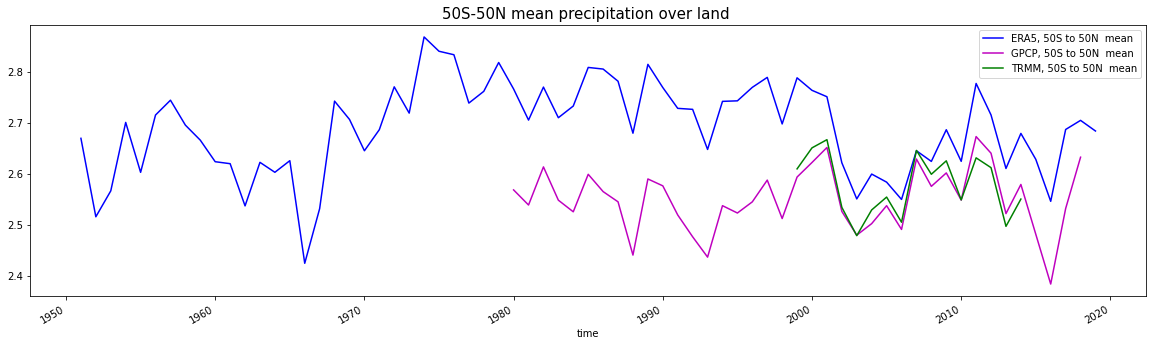

In [45]:
plt.figure(figsize=(20,5))
pr_era5_50landmean.resample(time='1Y').mean().plot(color='b',label='ERA5, 50S to 50N  mean')
pr_gpcp_50landmean.resample(time='1Y').mean().plot(color='m',label='GPCP, 50S to 50N  mean')
pr_trmm_50landmean.resample(time='1Y').mean().plot(color='g',label='TRMM, 50S to 50N  mean')
#pr_chirps_50mean.resample(time='1Y').mean().plot(color='gold',label='CHIRPS, 50S to 50N  mean')
plt.legend()
plt.title("50S-50N mean precipitation over land ",fontsize=15)

In [46]:
for pr,name in zip([pr_era5_50mean,pr_gpcp_50mean,pr_trmm_50mean],["ERA5","GPCP","TRMM"]):
    reg=pr.resample(time='1Y').mean()
    print('%s :'%name,sps.linregress(range(len(reg)),np.array(reg)))

ERA5 : LinregressResult(slope=0.0015464257706156777, intercept=3.1405684678450876, rvalue=0.6257115565942553, pvalue=8.994591758550531e-09, stderr=0.0002355279522996861)
GPCP : LinregressResult(slope=0.0006829382568461301, intercept=2.9076617169908574, rvalue=0.253838673333618, pvalue=0.11892312127436326, stderr=0.00042781892181747094)
TRMM : LinregressResult(slope=0.00434684395646664, intercept=2.89196155058291, rvalue=0.559646199142026, pvalue=0.02418230045721583, stderr=0.0017203245773455794)


## Global mean precip in orographic regions

In [29]:
def mean_orog_precip(thresh,pr,predictor,globmask=1):
    """Given the map of a precipitation predictor (for example the upslope flow u.grad(z)),
    compute a mask accoding to predictor>thresh and compute the according global mean precip"""
    dx = np.abs(np.array(predictor.latitude[1]-predictor.latitude[0])) #get the spatial resolution of the predictor to smooth accordingly
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(predictor>thresh),kwargs={"sigma":0.5/dx})>0.1)
    mask=mask.interp_like(pr)
    if type(globmask)!=int:
        globmask = globmask.interp_like(pr)
    pr_mean = spatial_mean(pr,box=None,mask=mask*globmask)
    return pr_mean.load()

In [30]:
%%time
pr_era5_50orogmean = mean_orog_precip(0.185,pr_era5_all,viwvgradz_era5_mean_s,landmask*(np.abs(pr_era5_all.latitude)<=50))
pr_gpcp_50orogmean = mean_orog_precip(0.185,pr_trmm_all,viwvgradz_era5_mean_s,landmask.interp_like(pr_gpcp_all)*(np.abs(pr_gpcp_all.latitude)<=50))
pr_trmm_50orogmean = mean_orog_precip(0.185,pr_trmm_all,viwvgradz_era5_mean_s,landmask)


CPU times: user 42.1 s, sys: 42.5 s, total: 1min 24s
Wall time: 16.9 s


Text(0.5, 1.0, '50S-50N mean precipitation over orographic regions')

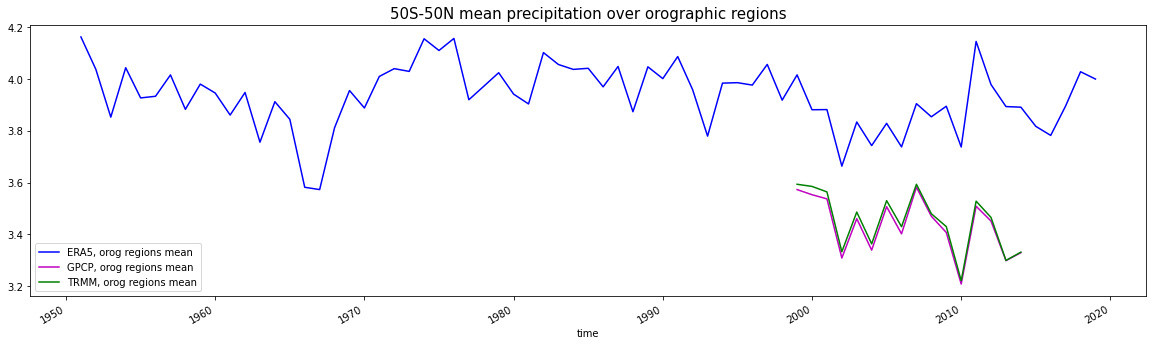

In [47]:
plt.figure(figsize=(20,5))
pr_era5_50orogmean.resample(time='1Y').mean().plot(color='b',label='ERA5, orog regions mean')
pr_gpcp_50orogmean.resample(time='1Y').mean().plot(color='m',label='GPCP, orog regions mean')
pr_trmm_50orogmean.resample(time='1Y').mean().plot(color='g',label='TRMM, orog regions mean')
#pr_chirps_50mean.resample(time='1Y').mean().plot(color='gold',label='CHIRPS, 50S to 50N  mean')
plt.legend()
plt.title("50S-50N mean precipitation over orographic regions",fontsize=15)

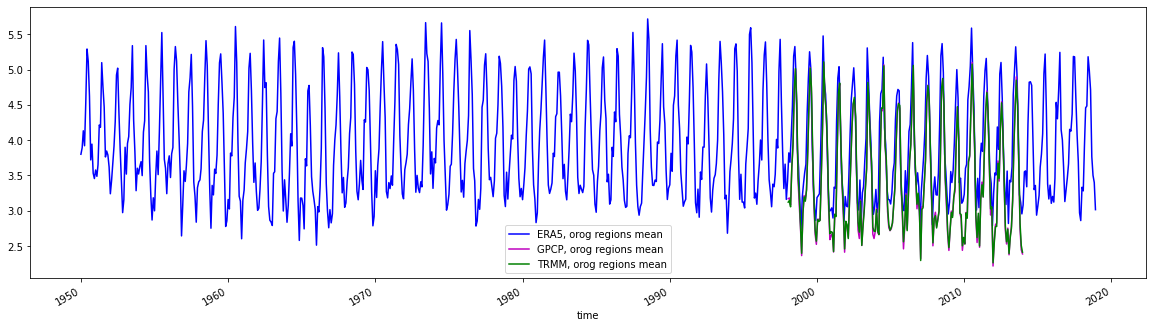

In [32]:
plt.figure(figsize=(20,5))
pr_era5_50orogmean.plot(color='b',label='ERA5, orog regions mean')
pr_gpcp_50orogmean.plot(color='m',label='GPCP, orog regions mean')
pr_trmm_50orogmean.plot(color='g',label='TRMM, orog regions mean')
#pr_chirps_50mean.resample(time='1Y').mean().plot(color='gold',label='CHIRPS, 50S to 50N  mean')
plt.legend()

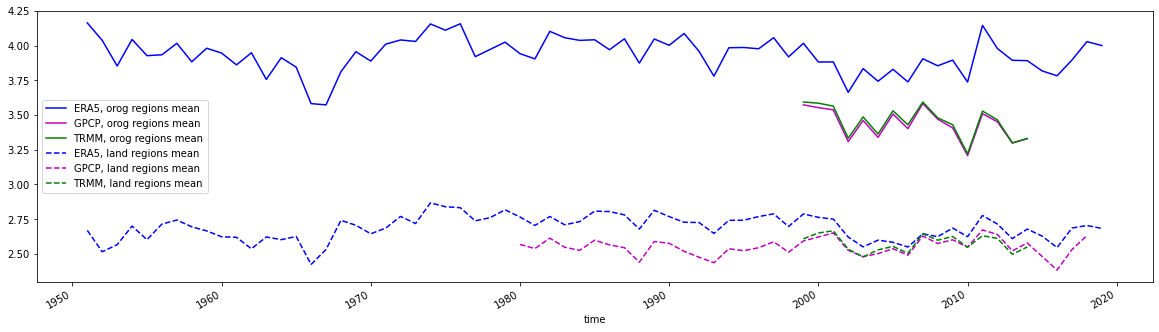

In [48]:
plt.figure(figsize=(20,5))
pr_era5_50orogmean.resample(time='1Y').mean().plot(color='b',label='ERA5, orog regions mean')
pr_gpcp_50orogmean.resample(time='1Y').mean().plot(color='m',label='GPCP, orog regions mean')
pr_trmm_50orogmean.resample(time='1Y').mean().plot(color='g',label='TRMM, orog regions mean')

pr_era5_50landmean.resample(time='1Y').mean().plot(color='b',linestyle='--',label='ERA5, land regions mean')
pr_gpcp_50landmean.resample(time='1Y').mean().plot(color='m',linestyle='--',label='GPCP, land regions mean')
pr_trmm_50landmean.resample(time='1Y').mean().plot(color='g',linestyle='--',label='TRMM, land regions mean')
#pr_chirps_50mean.resample(time='1Y').mean().plot(color='gold',label='CHIRPS, 50S to 50N  mean')
plt.legend()